In [1]:
client_id = 'a9e3e184-d841-457d-96eb-64447e00b568'
client_secret = '*7)_kA#Ov_4zf_%)Kh[2RdHu3ci7&dsuidbzt?z>'

In [2]:
import pandas as pd

import sentinelhub
from sentinelhub import SHConfig, WebFeatureService, Geometry, CRS, DataCollection, SentinelHubRequest, MimeType, bbox_to_dimensions

from PIL import Image
import os, json
from secrets import token_hex

import warnings
warnings.filterwarnings('ignore')

In [3]:
config = SHConfig()

# config.instance_id = sentinelhub_instance_id

config.sh_client_id = client_id
config.sh_client_secret = client_secret

In [95]:
def getDate(geom, datе, bands):
    
    betsiboka = Geometry(geometry=geom, crs=CRS.WGS84)

    
    evalscript = '''
    //VERSION=3
    function setup(){return{input:[{bands:'''+str(bands)+''',units:"DN"}],output:{id:"default",sampleType:"FLOAT32",bands:''' + str(len(bands)) + '''}};}
    function evaluatePixel(sample) {return [ ''' + ','.join(map(lambda x: f'sample.{x}', bands)) + '''];}
    '''
    
    r = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[SentinelHubRequest.input_data(data_collection=DataCollection.SENTINEL2_L1C, time_interval=datе, mosaicking_order='leastCC')],
        responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
        geometry=betsiboka,
        size=(64, 64),
        config=config,
        
    )

    r = r.get_data()[0]
    r = r.swapaxes(0, 2).swapaxes(1, 2)
    return dict(zip(bands, r))

In [96]:
def try_mkdir(path: str):
    try:
        os.mkdir(path)

    except FileNotFoundError:
        path_ = os.path.join(*os.path.split(path)[:-1])
        try_mkdir(path_)
        os.mkdir(path)

    except FileExistsError:
        pass


def save(path: str, data: dict):
    try_mkdir(path)
    extension = 'TIFF'
    
    for k, v in data.items():
        j = Image.fromarray(v)
        path_ = os.path.join(path, k) + '.' + extension
        j.save(path_)    

In [97]:
import shapely

In [98]:
%%time
bands = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12","CLM","dataMask"]

p = 'POLYGON ((72.16576044469464 60.44035609252692, 72.16576044469464 60.44634210700676, 72.17687709847911 60.44634210700676, 72.17687709847911 60.44035609252692, 72.16576044469464 60.44035609252692))'
p = shapely.wkt.loads(p)

datе = ('2021-02-01', '2021-02-07')
img = getDate(p, datе=datе, bands=bands)

Wall time: 650 ms


In [99]:
import numpy as np
import pickle
with open('data.p', 'wb') as fp:
    pickle.dump(img, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [100]:
# img

In [101]:
def real(data):
    assert 'B02' in data, 'B02 not set'
    assert 'B03' in data, 'B03 not set'
    assert 'B04' in data, 'B04 not set'
    
    B02, B03, B04 = data['B02'], data['B03'], data['B04']

    real = np.concatenate([B04.reshape(*B04.shape, 1), B03.reshape(*B03.shape, 1), B02.reshape(*B02.shape, 1)], axis=2)
    real = real * (.8 / real.max())
    
    data['real'] = real

In [102]:
from matplotlib import pyplot as plt

In [103]:
real(img)

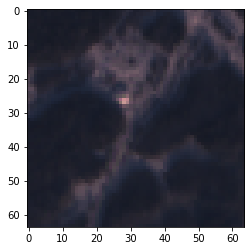

In [104]:
plt.imshow(img['real'])

In [105]:
img['real'].shape

(64, 64, 3)